In [21]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
pd.set_option("display.max_colwidth", None)


In [23]:
device

'cuda'

In [24]:
image_path = []
labels = []

for i in os.listdir('C:/Users/danie/OneDrive/Desktop/Data_science/ML/ImageClassification/afhq'):
    for label in os.listdir(f'C:/Users/danie/OneDrive/Desktop/Data_science/ML/ImageClassification/afhq/{i}'):
        for image in os.listdir(f'C:/Users/danie/OneDrive/Desktop/Data_science/ML/ImageClassification/afhq/{i}/{label}'):
            image_path.append(f'C:/Users/danie/OneDrive/Desktop/Data_science/ML/ImageClassification/afhq/{i}/{label}/{image}')
            labels.append(label)

In [25]:
data_df = pd.DataFrame(zip(image_path,labels),columns=['image_path','labels'])

In [26]:
data_df.head(2)

,image_path,labels
0,C:/Users/danie/OneDrive/Desktop/Data_science/ML/ImageClassification/afhq/train/cat/flickr_cat_000002.jpg,cat
1,C:/Users/danie/OneDrive/Desktop/Data_science/ML/ImageClassification/afhq/train/cat/flickr_cat_000003.jpg,cat


In [27]:
train = data_df.sample(frac=.7)
test = data_df.drop(train.index)

val = test.sample(frac=.5)
test = test.drop(val.index)

In [28]:
print(f'Val Shape: {val.shape} , Train Shape : {train.shape} , Test Shape: {test.shape}')

Val Shape: (2420, 2) , Train Shape : (11291, 2) , Test Shape: (2419, 2)


In [29]:
label_encoder = LabelEncoder()

label_encoder.fit(data_df['labels'])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
   ] 
)

In [30]:
class CustomImageDataSet(Dataset):
    def __init__(self,dataframe,transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)
        
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self,index):
        image_path = self.dataframe.iloc[index,0]
        label = self.labels[index]
        
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image).to(device)
            
        return image,label
    
    

In [31]:
train_dataset = CustomImageDataSet(dataframe=train,transform=transform)
val_dataset = CustomImageDataSet(dataframe=val,transform=transform)
test_dataset = CustomImageDataSet(dataframe=test,transform=transform)

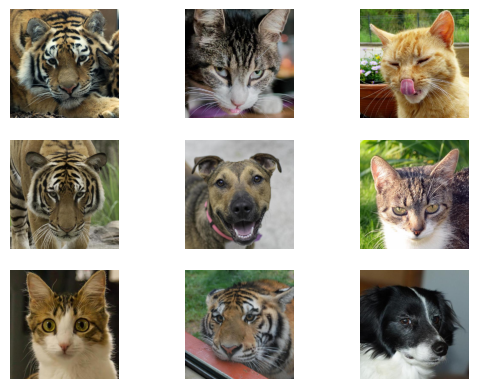

In [163]:
n_rows = 3 
n_cols = 3 
f,axarr = plt.subplots(n_rows,n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image= Image.open(data_df.sample(n=1)['image_path'].iloc[0]).convert('RGB')
        axarr[row,col].imshow(image)
        axarr[row,col].axis('off')

In [33]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS =  10

In [34]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [35]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=1)
        
        self.pooling = nn.MaxPool2d(2,2)
        
        self.relu=nn.ReLU()
        
        self.flatten=nn.Flatten()
        self.linear=nn.Linear((128*16*16),128)
        
        self.output = nn.Linear(128,len(data_df['labels'].unique()))
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x=self.pooling(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.pooling(x)
        x = self.relu(x)
        
        x = self.flatten(x)
        x = self.linear(x)
        x=self.output(x)
        return x

In [36]:
model = Net().to(device)

In [37]:
from torchsummary import summary
summary(model,input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [38]:
criterion = nn.CrossEntropyLoss()
optimazer = Adam(model.parameters(),lr=LR)

In [39]:
total_loss_train_plot =[]
total_loss_validation_plot=[]
total_acc_train_plot=[]
total_acc_validation_plot=[]


In [71]:
for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0 
    total_acc_validation = 0
    total_loss_validation=0
    for inputs,labels in train_loader:
        optimazer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs,labels)
        total_loss_train += train_loss.item()
        
        train_loss.backward()
        train_acc = (torch.argmax(outputs,axis=1)==labels).sum().item()
        total_acc_train += train_acc
        optimazer.step()
        
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs,labels)
            total_loss_validation += val_loss.item()
            
            val_acc = (torch.argmax(outputs,axis=1)==labels).sum().item()
            total_acc_validation +=val_acc
        
    total_loss_train_plot.append(round(total_loss_train/len(train_loader),4))
    total_loss_validation_plot.append(round(total_loss_validation/len(val_loader),4))
    
    total_acc_train_plot.append(round((total_acc_train/len(train_dataset))*100,4))
    total_acc_validation_plot.append(round((total_acc_validation/len(val_dataset))*100,4))    
            
    print(f'Epoch:{epoch+1}/{EPOCHS}, Train LOSS: {total_loss_train_plot[epoch]}, Train ACC: {total_acc_train_plot[epoch]}')
    print(f'Epoch:{epoch+1}/{EPOCHS}, Val LOSS: {total_loss_validation_plot[epoch]}, Val ACC: {total_acc_validation_plot[epoch]}')

Epoch:1/10, Train LOSS: 0.4513, Train ACC: 81.5428
Epoch:1/10, Val LOSS: 92.3967, Val ACC: 92.3967
Epoch:2/10, Train LOSS: 0.1905, Train ACC: 93.0121
Epoch:2/10, Val LOSS: 95.124, Val ACC: 95.124
Epoch:3/10, Train LOSS: 0.1225, Train ACC: 95.616
Epoch:3/10, Val LOSS: 94.2149, Val ACC: 94.2149
Epoch:4/10, Train LOSS: 0.0892, Train ACC: 96.8559
Epoch:4/10, Val LOSS: 95.5785, Val ACC: 95.5785
Epoch:5/10, Train LOSS: 0.0654, Train ACC: 97.6264
Epoch:5/10, Val LOSS: 96.405, Val ACC: 96.405
Epoch:6/10, Train LOSS: 0.0419, Train ACC: 98.5298
Epoch:6/10, Val LOSS: 95.9091, Val ACC: 95.9091
Epoch:7/10, Train LOSS: 0.0356, Train ACC: 98.7689
Epoch:7/10, Val LOSS: 96.1983, Val ACC: 96.1983
Epoch:8/10, Train LOSS: 0.0256, Train ACC: 99.2206
Epoch:8/10, Val LOSS: 96.5289, Val ACC: 96.5289
Epoch:9/10, Train LOSS: 0.0179, Train ACC: 99.4952
Epoch:9/10, Val LOSS: 94.7107, Val ACC: 94.7107
Epoch:10/10, Train LOSS: 0.0134, Train ACC: 99.6457
Epoch:10/10, Val LOSS: 96.1983, Val ACC: 96.1983


In [79]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs,labels in test_loader:
        outputs = model(inputs)
        acc = (torch.argmax(outputs,axis=1)==labels).sum().item()
        total_acc_test += acc
        loss_test = criterion(outputs,labels)
        total_loss_test += loss_test.item()
        
    print(f'Acc score: {round((total_acc_test/len(test_dataset)*100),4)}% ,Loss score: {round(total_loss_test/len(test_loader),4)}')
        

Acc score: 96.0314% ,Loss score: 0.1376


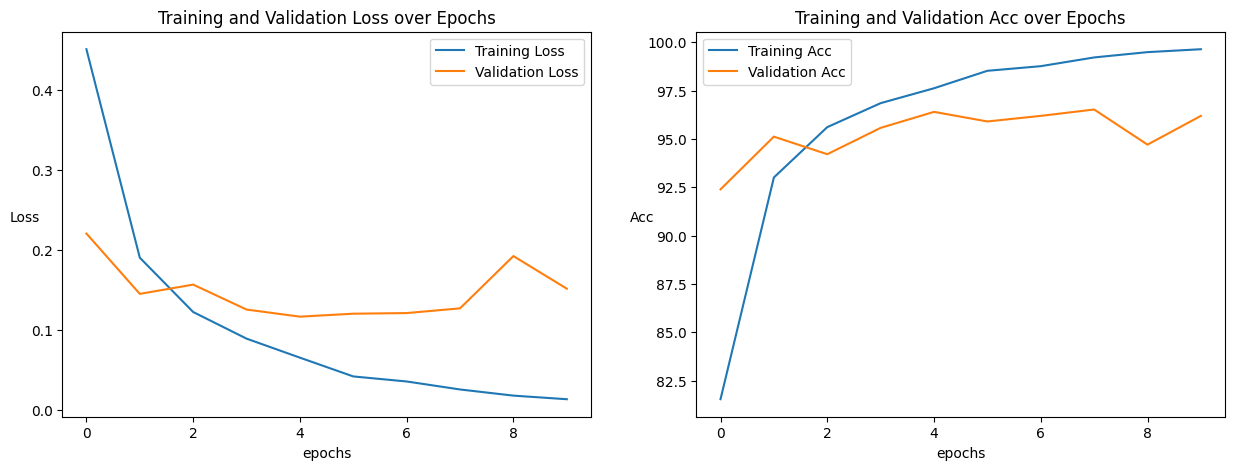

In [106]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(total_loss_train_plot,label='Training Loss')
plt.plot(total_loss_validation_plot,label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('epochs')
plt.ylabel('Loss',rotation=0)
plt.legend()
plt.subplot(1,2,2)
plt.plot(total_acc_train_plot,label='Training Acc')
plt.plot(total_acc_validation_plot,label='Validation Acc')
plt.title('Training and Validation Acc over Epochs')
plt.xlabel('epochs')
plt.ylabel('Acc',rotation=0)
plt.legend()
plt.show()

In [158]:
def predict_image(image_path):
    image= Image.open(image_path).convert('RGB')
    image = transform(image).to(device)
    print(image.shape)
    prediction=model(image.unsqueeze(0))
    output = torch.argmax(prediction,axis=1).item()
    return label_encoder.inverse_transform([output])

In [159]:
predict_image("C:/Users/danie/Downloads/images.jpg")

torch.Size([3, 128, 128])


array(['wild'], dtype=object)